In [1]:
import pandas as pd
import numpy as np

In [2]:
temp_df = pd.read_csv("C:\\Users\\Лев\\Projects\\Diploma\\sbp2.csv", sep=';')
temp_df['time'] = pd.to_datetime(temp_df['time'], dayfirst=True)
temp_df = temp_df.sort_values(by=['time'])
temp = pd.DataFrame(pd.date_range(start=temp_df['time'][55215], end=temp_df['time'][0], freq='3 h'), columns=['time'])
temp = temp.set_index('time').join(temp_df.set_index('time'), how='left')
temp = temp['T'].ffill()
temp.index = pd.date_range(start=temp_df['time'][55215], end=temp_df['time'][0], freq='3 h')

In [3]:
from sktime.forecasting.model_selection import temporal_train_test_split

temp_train, temp_test = temporal_train_test_split(temp, test_size=2920)

In [4]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# plot_pacf(temp_train)

In [5]:
import warnings 
warnings.filterwarnings('ignore')

In [9]:
import pmdarima as pm

arima_model = pm.ARIMA(order=(12,1,6))
arima_model.fit(temp_train)
np.mean(np.abs(arima_model.resid()))

0.9377249343378221

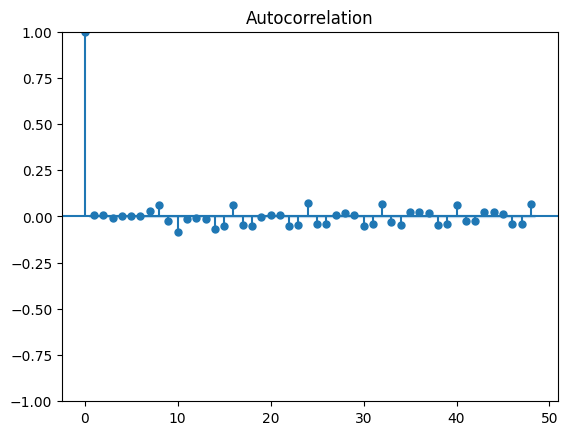

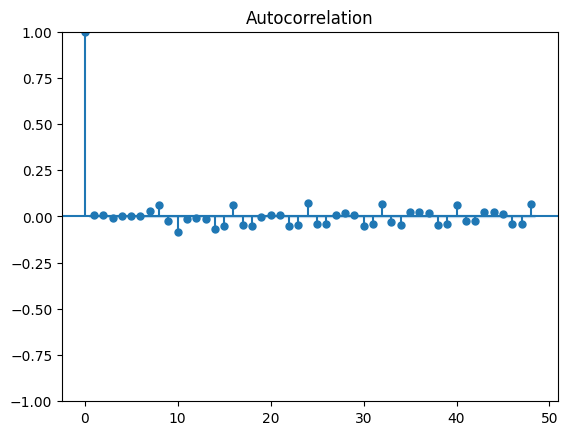

In [11]:
plot_acf(arima_model.resid())

In [12]:
def mae(y_true, y_pred): 
    return np.mean(np.abs(y_true - y_pred))

In [13]:
results = np.array([arima_model.predict(n_periods=24)])

for i in range(358):
    print(round(i / 358, 4))
    arima_model.update(temp_test[8*i:8*(i+1)], maxiter=-1)
    results = np.append(results, [arima_model.predict(n_periods=24)], axis=0)

0.0
0.0028
0.0056
0.0084
0.0112
0.014
0.0168
0.0196
0.0223
0.0251
0.0279
0.0307
0.0335
0.0363
0.0391
0.0419
0.0447
0.0475
0.0503
0.0531
0.0559
0.0587
0.0615
0.0642
0.067
0.0698
0.0726
0.0754
0.0782
0.081
0.0838
0.0866
0.0894
0.0922
0.095
0.0978
0.1006
0.1034
0.1061
0.1089
0.1117
0.1145
0.1173
0.1201
0.1229
0.1257
0.1285
0.1313
0.1341
0.1369
0.1397
0.1425
0.1453
0.148
0.1508
0.1536
0.1564
0.1592
0.162
0.1648
0.1676
0.1704
0.1732
0.176
0.1788
0.1816
0.1844
0.1872
0.1899
0.1927
0.1955
0.1983
0.2011
0.2039
0.2067
0.2095
0.2123
0.2151
0.2179
0.2207
0.2235
0.2263
0.2291
0.2318
0.2346
0.2374
0.2402
0.243
0.2458
0.2486
0.2514
0.2542
0.257
0.2598
0.2626
0.2654
0.2682
0.2709
0.2737
0.2765
0.2793
0.2821
0.2849
0.2877
0.2905
0.2933
0.2961
0.2989
0.3017
0.3045
0.3073
0.3101
0.3128
0.3156
0.3184
0.3212
0.324
0.3268
0.3296
0.3324
0.3352
0.338
0.3408
0.3436
0.3464
0.3492
0.352
0.3547
0.3575
0.3603
0.3631
0.3659
0.3687
0.3715
0.3743
0.3771
0.3799
0.3827
0.3855
0.3883
0.3911
0.3939
0.3966
0.3994
0.4022


In [14]:
np.savetxt("arima2res.csv", results)

0.9970693626764456

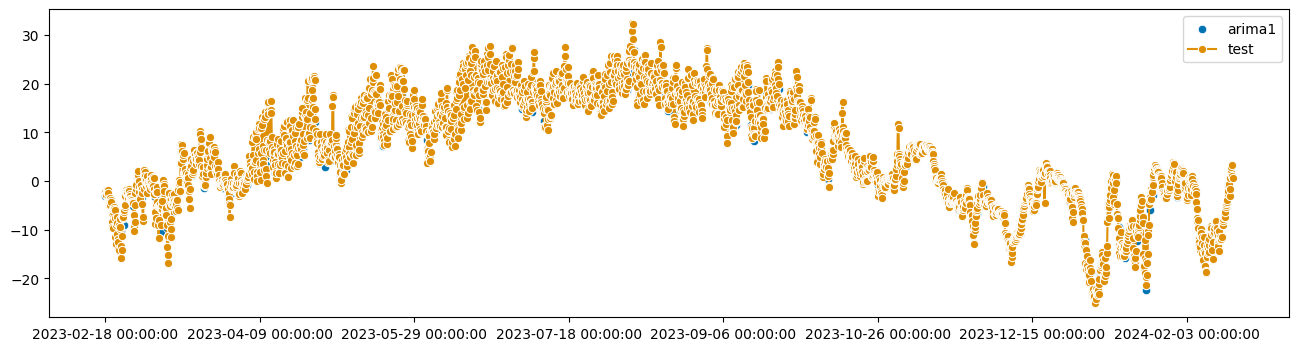

In [18]:
results_3h = pd.Series(results[:,0])
results_3h.index = temp_test[[8*i for i in range(359)]].index

from sktime.utils.plotting import plot_series

plot_series(results_3h, temp_test, labels = ['arima1', 'test'])
mae(results_3h, temp_test[[8*i for i in range(359)]])


In [20]:
maes = [mae(results[:,j], temp_test[[8*i + j for i in range(359)]]) for j in range(24)]
maes

[0.9970693626764456,
 1.4278709334488269,
 1.6645749930639915,
 1.8761612714965976,
 2.159670343792745,
 2.4004151679135575,
 2.6361166616715193,
 2.4311657359053953,
 2.502797666313283,
 2.7534603429729247,
 2.9186530531432218,
 3.0398729558479434,
 3.216524256378739,
 3.3667754419924143,
 3.436351333552424,
 3.1789361305959503,
 3.1035396833728788,
 3.2897090891529706,
 3.4151155521308993,
 3.6342913719833674,
 3.763670673759352,
 3.912882342826288,
 3.894035791145315,
 3.606252500262609]

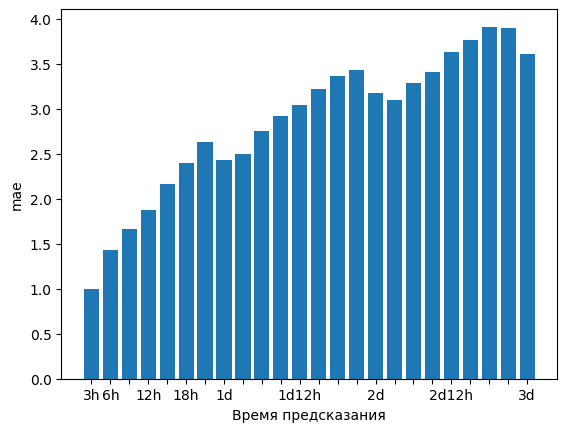

In [17]:
import matplotlib.pyplot as plt

names=['3h','6h','               ','12h','              ','18h','             ','1d','            ','           ','          ','1d12h','         ','        ','       ','2d', ' ','  ','   ','2d12h','    ','     ','      ','3d']
plt.bar(x=names, height=maes)
plt.xlabel("Время предсказания")
plt.ylabel("mae")
plt.show()

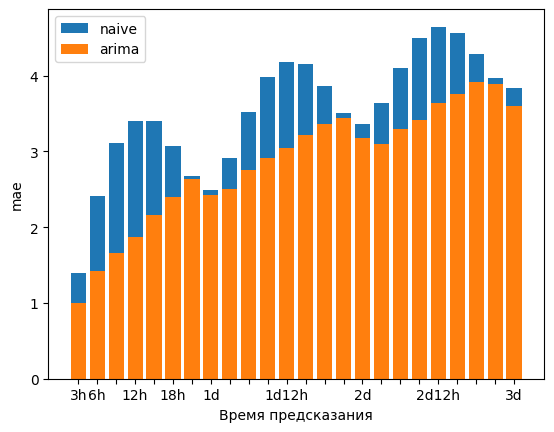

In [25]:
maes2 = [mae(temp_test[i:].values, temp_test[:-i].values) for i in range(1, 25)]

import matplotlib.pyplot as plt

names=['3h','6h','               ','12h','              ','18h','             ','1d','            ','           ','          ','1d12h','         ','        ','       ','2d', ' ','  ','   ','2d12h','    ','     ','      ','3d']
plt.bar(x=names, height=maes2, label='naive')
plt.bar(x=names, height=maes, label='arima')
plt.xlabel("Время предсказания")
plt.ylabel("mae")
plt.legend()
plt.show()